In [15]:
import pandas as pd
import pandas_bokeh
import bokeh
import geopandas as gpd
pandas_bokeh.output_notebook()

pcr_slovakia = pd.read_csv("https://raw.githubusercontent.com/Institut-Zdravotnych-Analyz/covid19-data/main/PCR_Tests/OpenData_Slovakia_Covid_PositiveTests_District.csv",
sep=';',
parse_dates=['Datum'],
index_col='Datum')


Loading BokehJS ...

In [16]:
pcr_slovakia.head()

,Okres,Dennych.prirastkov
Datum,,
2020-10-08,Bánovce nad Bebravou,6
2020-10-08,Banská Bystrica,9
2020-10-08,Banská Štiavnica,2
2020-10-08,Bardejov,13
2020-10-08,Bratislava,26


In [17]:
okresy_sum_7days = pcr_slovakia\
    .groupby([pd.Grouper(freq='7D'), 'Okres'])\
    .sum()\
    .unstack()\
    .fillna(0)

okresy_sum_7days.columns = okresy_sum_7days.columns.get_level_values(1)

okresy_sum_7days.reset_index(inplace=True)
okresy_sum_7days['Date'] = okresy_sum_7days['Datum'].dt.strftime('%YWeek%U')
okresy_sum_7days.set_index('Date', inplace=True)
okresy_sum_7days.drop('Datum',axis=1, inplace=True)

okresy_sum_7days = okresy_sum_7days.transpose()
okresy_sum_7days.reset_index(inplace=True)
okresy_sum_7days['Okres'] = okresy_sum_7days['Okres'].astype('string')



In [18]:
okresy_sum_7days

Date,Okres,2020Week40,2020Week41,2020Week42,2020Week43,2020Week44,2020Week45,2020Week46,2020Week47,2020Week48,...,2022Week03,2022Week04,2022Week05,2022Week06,2022Week07,2022Week08,2022Week09,2022Week10,2022Week11,2022Week12
0,Banská Bystrica,135.0,339.0,367.0,548.0,364.0,199.0,159.0,251.0,349.0,...,1185.0,2038.0,2530.0,2475.0,2555.0,1733.0,1625.0,1405.0,1186.0,181.0
1,Banská Štiavnica,33.0,26.0,31.0,11.0,19.0,22.0,21.0,19.0,22.0,...,207.0,192.0,332.0,254.0,255.0,223.0,158.0,134.0,99.0,7.0
2,Bardejov,537.0,495.0,508.0,223.0,191.0,134.0,95.0,105.0,107.0,...,881.0,1541.0,1610.0,1347.0,1139.0,964.0,793.0,748.0,729.0,74.0
3,Bratislava,436.0,562.0,848.0,908.0,693.0,431.0,505.0,743.0,1131.0,...,5457.0,9141.0,10453.0,9560.0,8207.0,6750.0,6776.0,6956.0,8024.0,1206.0
4,Brezno,35.0,118.0,247.0,197.0,121.0,115.0,93.0,73.0,124.0,...,591.0,903.0,1201.0,1118.0,659.0,497.0,415.0,337.0,275.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Čadca,194.0,398.0,420.0,741.0,549.0,284.0,142.0,177.0,217.0,...,1085.0,1803.0,2211.0,1878.0,1254.0,901.0,675.0,454.0,423.0,72.0
68,Šaľa,27.0,21.0,32.0,61.0,53.0,64.0,77.0,82.0,103.0,...,523.0,882.0,1199.0,1072.0,1149.0,827.0,575.0,567.0,549.0,67.0
69,Žarnovica,19.0,28.0,45.0,31.0,42.0,17.0,31.0,49.0,35.0,...,157.0,281.0,379.0,459.0,424.0,293.0,228.0,183.0,222.0,24.0
70,Žiar nad Hronom,88.0,60.0,82.0,58.0,61.0,48.0,85.0,71.0,83.0,...,286.0,558.0,841.0,1234.0,1157.0,803.0,669.0,484.0,319.0,73.0


In [19]:
okresy = gpd.read_file('shapes/okres_2.shp')[['NM3','geometry']]
okresy.rename(columns={'NM3': 'Okres'},inplace = True)

In [20]:
for city in ['Bratislava', 'Košice']:
    new_row = okresy[(okresy['Okres'].str.contains(city))
                     & (~okresy['Okres'].str.contains("-"))]\
        .dissolve()\
        .explode(index_parts=False)

    new_row['Okres'] = city
    okresy.drop(okresy[(okresy['Okres'].str.contains(city))
                       & (~okresy['Okres'].str.contains("-"))].index, inplace=True)
    okresy = okresy.append(new_row, ignore_index=True)


In [21]:
okresy_sum_7days = okresy.join(okresy_sum_7days.set_index('Okres'), on='Okres', how='left')

In [22]:
okresy_sum_7days.plot_bokeh(
    title='Počet pozitívnych PCR testov',
    slider=[c for c in okresy_sum_7days.columns if c[4:8] == "Week"],
    slider_name="Týždeň (od 9. týždňa 2020)",
    colorbar_tick_format="0.0a",
    colormap="RdYlGn",
    colormap_range=[
        okresy_sum_7days.loc[:, [
            c for c in okresy_sum_7days.columns if c[4:8] == "Week"]].quantile(p).quantile(p)
        for p in [0.10, 0.90]
    ],
    hovertool_string="""<h1>@Okres</h1>
                    <h3>@Colormap</h3>""",
    figsize=(1600, 600),
)


Column(id='1400', ...)

In [23]:
okresy_per_change_7days = pcr_slovakia\
    .groupby([pd.Grouper(freq='7D'), 'Okres'])\
    .sum()\
    .unstack()\
    .fillna(0)

okresy_per_change_7days.columns = okresy_per_change_7days.columns.get_level_values(1)

okresy_per_change_7days.reset_index(inplace=True)
okresy_per_change_7days['Date'] = okresy_per_change_7days['Datum'].dt.strftime('%YWeek%U')
okresy_per_change_7days.set_index('Date', inplace=True)
okresy_per_change_7days.drop('Datum',axis=1, inplace=True)

okresy_per_change_7days = okresy_per_change_7days[[c for c in okresy_per_change_7days.columns]].pct_change().fillna(0)*100


okresy_per_change_7days = okresy_per_change_7days.transpose()
okresy_per_change_7days.reset_index(inplace=True)
okresy_per_change_7days['Okres'] = okresy_per_change_7days['Okres'].astype('string')

okresy_per_change_7days = okresy.join(okresy_per_change_7days.set_index('Okres'), on='Okres', how='left')

In [24]:
okresy_per_change_7days.plot_bokeh(
    title='Pozitívne PCR testy - Zmena oproti minulému týždňu',
    slider=[c for c in okresy_sum_7days.columns if c[4:8] == "Week"],
    slider_name="Týždeň (od 9. týždňa 2020)",
    colormap="RdYlGn",
    colormap_range=[-30,30
    ],
    hovertool_string="""<h1>@Okres</h1>
                    <h3>@Colormap %</h3>""",
    figsize=(1600, 600),
)

Column(id='1554', ...)

In [26]:
okresy_per_change_7days

,Okres,geometry,2020Week40,2020Week41,2020Week42,2020Week43,2020Week44,2020Week45,2020Week46,2020Week47,...,2022Week03,2022Week04,2022Week05,2022Week06,2022Week07,2022Week08,2022Week09,2022Week10,2022Week11,2022Week12
0,Malacky,"POLYGON Z ((-551128.940 -1226442.410 -0.000, -...",0.0,116.666667,32.967033,28.925620,-39.102564,-26.315789,-38.571429,230.232558,...,210.355987,65.589155,18.073048,-4.853333,-8.520179,-26.225490,-24.833887,5.193370,1.575630,-89.762151
1,Pezinok,"POLYGON Z ((-549655.720 -1250803.710 -0.000, -...",0.0,169.565217,19.354839,-38.513514,7.692308,-51.020408,20.833333,37.931034,...,125.000000,76.595745,15.194110,-8.425334,-12.246193,-27.042661,-12.289395,20.564972,14.432990,-86.814087
2,Senec,"POLYGON Z ((-544036.950 -1267282.960 -0.000, -...",0.0,25.454545,113.043478,24.489796,-42.622951,-10.476190,25.531915,-3.389831,...,157.936508,71.876923,1.718582,-14.325942,-16.474938,-16.232169,-4.403993,5.589681,5.584642,-86.666667
3,Dunajská Streda,"POLYGON Z ((-551738.260 -1279656.770 -0.000, -...",0.0,-29.192547,69.298246,87.046632,16.897507,-17.772512,-8.645533,-11.987382,...,165.205224,17.762926,-24.492234,-6.843354,-10.828025,-34.333333,-7.324148,-12.363067,12.946429,-86.877470
4,Galanta,"POLYGON Z ((-518125.470 -1262838.260 -0.000, -...",0.0,43.548387,76.404494,8.917197,-21.637427,0.746269,6.666667,13.888889,...,146.282974,78.773126,1.034858,7.061995,8.157100,-33.193669,-17.630662,-2.284264,2.597403,-86.160338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Sobrance,"POLYGON Z ((-192766.670 -1219080.840 -0.000, -...",0.0,6.250000,25.490196,1.562500,-44.615385,-30.555556,-52.000000,66.666667,...,142.592593,69.465649,55.855856,1.734104,-17.897727,-30.449827,-4.975124,14.136126,-5.504587,-88.349515
68,Spišská Nová Ves,"POLYGON Z ((-314866.330 -1203762.450 -0.000, -...",0.0,76.666667,75.471698,51.612903,-3.900709,-26.568266,33.668342,-13.533835,...,160.000000,80.173348,-8.298256,2.426230,3.777209,-30.783467,-21.568627,-1.931818,-23.290846,-77.794562
69,Trebišov,"POLYGON Z ((-241236.400 -1232569.910 -0.000, -...",0.0,-11.409396,48.484848,3.571429,-0.492611,-3.465347,-36.410256,44.354839,...,132.024169,69.921875,30.881226,-7.259953,-4.987374,-18.405316,-10.179153,10.244787,-17.927632,-87.174349
70,Bratislava,"POLYGON Z ((-564573.150 -1277016.250 -0.000, -...",0.0,28.899083,50.889680,7.075472,-23.678414,-37.806638,17.169374,47.128713,...,122.643819,67.509621,14.352915,-8.543002,-14.152720,-17.753138,0.385185,2.656434,15.353652,-84.970090


<AxesSubplot:title={'center':'% zmena pozitívnych PCR'}, ylabel='Okres'>

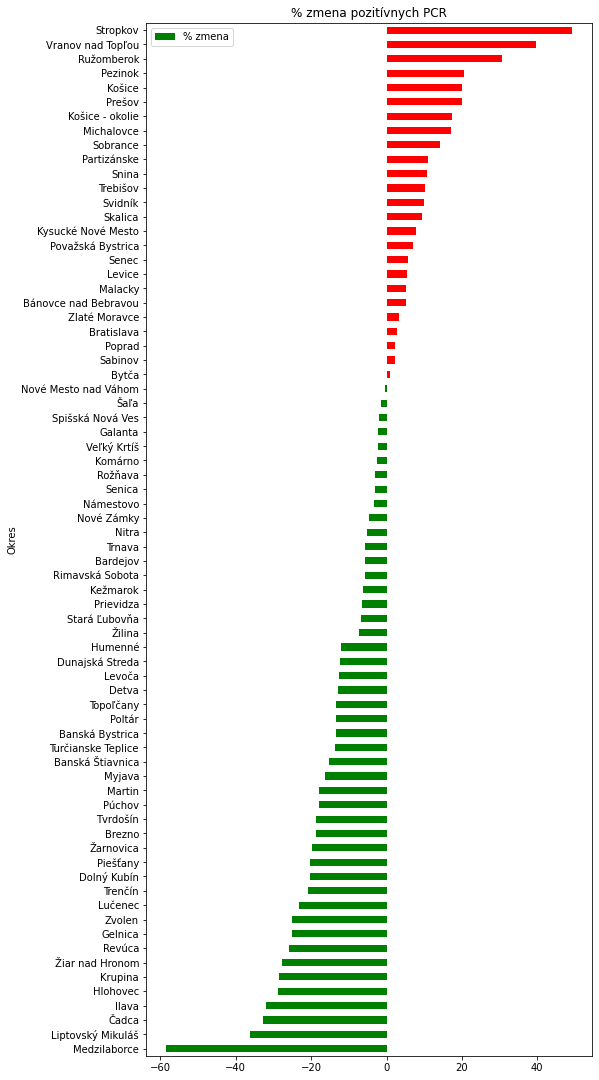

In [28]:
okresy_per_change_7days.sort_values('2022Week10').plot(
    title='% zmena pozitívnych PCR',
    x='Okres',
    y='2022Week10',
    kind='barh',
    label='% zmena',
    figsize=(8, 19),
    color=(okresy_per_change_7days['2022Week10'].sort_values() > 0).map({True: 'r', False: 'g'}))
